In [42]:
# Approach 1: Find derivative of graph, delete points with too high of a change in slope

import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
from scipy import interpolate
from scipy.signal import savgol_filter

# Load file into 2d list
with open('../data/P7132033_37.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats and remove low frequency values
zc_x = list()
zc_y = list()
for x, y in zc_str:
    if float(y) > 44000:
        zc_x.append(float(x))
        zc_y.append(float(y))

# Get dy and dy2
prev_y = 0
dy = list()
dy2 = list()
for y in zc_y:
    dy.append(abs(y-prev_y))
    if not len(dy) == 1:
        dy2.append(abs(dy[-1]-dy[-2]))
    prev_y = y
    
# Define cutoff dy for ignoring noise
cutoff = 700
    
# Smooth graph- Savitsky-Golay filter
yhat2 = savgol_filter(zc_y, 27, 2)
yhat3 = savgol_filter(zc_y, 17, 3)
yhat4 = savgol_filter(zc_y, 17, 4) #best fit so far

# ELIMINATE NOISE
i = 0
noiseless_x = list()
noiseless_y = list()
while i < len(dy2):
    if dy2[i] < cutoff:
        noiseless_x.append(zc_x[i])
        noiseless_y.append(yhat4[i])
    i += 1

# Graph data
trace_noisy = graphs.Scatter(
                            x = zc_x, 
                            y = zc_y,
                            mode = 'markers',
                            name = 'ZC- noisy'
                        )
trace_smooth = graphs.Scatter(
                            x = zc_x, 
                            y = yhat4,
                            name = 'ZC- smoothed'
                        )
trace_noiseless = graphs.Scatter(
                            x = noiseless_x, 
                            y = noiseless_y,
                            mode = 'markers',
                            name = 'ZC- noiseless'
                         )
trace_dy2 = graphs.Scatter(
                            x = zc_x, 
                            y = dy, 
                            name = 'Derivative- noisy'
                         )
trace_cutoff = graphs.Scatter(
                            x = [zc_x[0], zc_x[-1]], 
                            y = [cutoff, cutoff], 
                            name = 'Cutoff'
                         )
trace = [trace_noisy, trace_smooth, trace_noiseless, trace_cutoff, trace_dy2]
py.iplot(trace, filename='P7132033_37_1')

In [2]:
# Approach 2: Smooth graph, and take comparisons of smoothed and unsmoothed graph. More different points are deleted

import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
from scipy import interpolate
from scipy.signal import savgol_filter

# Load file into 2d list
with open('../data/P7132033_37.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats and remove low frequency values
zc_x = list()
zc_y = list()
for x, y in zc_str:
    if float(y) > 44000:
        zc_x.append(float(x))
        zc_y.append(float(y))
    
# Define cutoff dy for ignoring noise
cutoff = 300
    
# Smooth graph- Savitsky-Golay filter
yhat2 = savgol_filter(zc_y, 27, 2)
yhat3 = savgol_filter(zc_y, 17, 3)
yhat4 = savgol_filter(zc_y, 7, 4) # best fit so far

# Compare smoothed and original
i = 0
noiseless_y = list()
noiseless_x = list()
dy = list()
while i < len(zc_x):
    dy.append(abs(zc_y[i] - yhat4[i]))
    if dy[-1] < cutoff:
        noiseless_y.append(zc_y[i])
        noiseless_x.append(zc_x[i])
    i += 1
    
# Graph data
trace_noisy = graphs.Scatter(
                            x = zc_x, 
                            y = zc_y,
                            mode = 'markers',
                            name = 'ZC- noisy'
                        )
trace_smooth = graphs.Scatter(
                            x = zc_x, 
                            y = yhat4,
                            name = 'ZC- smoothed'
                        )
trace_noiseless = graphs.Scatter(
                            x = noiseless_x, 
                            y = noiseless_y,
                            mode = 'markers',
                            name = 'ZC- noiseless'
                         )
trace_dy = graphs.Scatter(
                            x = zc_x, 
                            y = dy, 
                            name = 'Derivative- noisy'
                         )
trace_cutoff = graphs.Scatter(
                            x = [zc_x[0], zc_x[-1]], 
                            y = [cutoff, cutoff], 
                            name = 'Cutoff'
                         )
trace = [trace_noisy, trace_smooth, trace_noiseless, trace_cutoff, trace_dy]
py.iplot(trace, filename='P7132033_37_2')

In [31]:
# Approach 3: Smooth graph, and take comparisons of smoothed and unsmoothed graph. Go by chunks and take average difference between smooth and unsmoothed.
# Approach 3.1: Chunk graph into pulses, preserve dense portions of a given pulse

import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
from batcall import batcall
from scipy import interpolate
from scipy.signal import savgol_filter

# Magic numbers
dy_cutoff = 100
density = 1250
pulse_size = 120
pulse_dx = .04

# Load file into 2d list
filename = 'P7132033_37'
with open('../data/'+ filename + '.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats
zc_x = list()
zc_y = list()
for x, y in zc_str:
        zc_x.append(float(x))
        zc_y.append(float(y))

# Smooth graph- Savitsky-Golay filter
yhat2 = savgol_filter(zc_y, 27, 2)
yhat3 = savgol_filter(zc_y, 17, 3)
yhat4 = savgol_filter(zc_y, 17, 4) # best fit so far
    
# Segment pulses
pulses = list()
pulse = list()
pulse_lines = list()
prev_x = 0
for x, y in zip(zc_x, zc_y):
    if x - prev_x <= pulse_dx:
        pulse.append([x, y])
    else:
        pulses.append(pulse)
        pulse = [[x, y]]
        pulse_lines.append(prev)
        pulse_lines.append(x)
    prev_x = x
    
# Clean pulses
clean_pulses = list()
smooth_pulses = list()
for pulse in pulses:
    if len(pulse) < pulse_size:
        continue
    
    smooth_pulse = zip([point[0] for point in pulse], savgol_filter([point[1] for point in pulse], 17, 4))
    
    clean_pulse = list()
    i = 0
    neighbors = list()
    for x, y in pulse:
        neighbors.append([point for point in pulse if numpy.sqrt((x - point[0])**2 + (y - point[1])**2) < density])

    for neighbor in neighbors:
        for point in neighbor:
            if point not in clean_pulse:
                clean_pulse.append(point)
    
    for i, point in enumerate(smooth_pulse):
        if(point[0] == clean_pulse[i][0]):
            if numpy.sqrt((point[0] - clean_pulse[i][0])**2 + (y - point[1])**2) < density]
    
    clean_pulses.append(clean_pulse)
    smooth_pulses.append(smooth_pulse)

pulses_x = list()
pulses_y = list()
for pulse in pulses:
    for point in pulse:
        pulses_x.append(point[0])
        pulses_y.append(point[1])
        
smooth_pulses_y = list()
for pulse in smooth_pulses:
    for point in pulse:
        smooth_pulses_y.append(point[1])
        
clean_pulses_x = list()
clean_pulses_y = list()
for pulse in clean_pulses:
    for point in pulse:
        clean_pulses_x.append(point[0])
        clean_pulses_y.append(point[1])
            
# Graph data
trace_noisy = graphs.Scatter(
                            x = pulses_x, 
                            y = pulses_y,
                            mode = 'markers',
                            name = 'ZC- noisy'
                        )
trace_smooth = graphs.Scatter(
                            x = clean_pulses_x, 
                            y = smooth_pulses_y,
                            name = 'ZC- smoothed'
                        )
trace_noiseless = graphs.Scatter(
                            x = clean_pulses_x, 
                            y = clean_pulses_y,
                            mode = 'markers',
                            name = 'ZC- noiseless'
                         )

shapes = list()
for i in pulse_lines:
    shapes.append({'type': 'line',
                   'xref': 'x',
                   'yref': 'y',
                   'x0': i,
                   'y0': 0,
                   'x1': i,
                   'y1': 100000,
                   'line': {
                        'color': 'rgb(139, 0, 0)',
                        'width': 1,
                    },
                  })
layout = graphs.Layout(shapes=shapes)
trace = [trace_noisy, trace_noiseless]
figure={
    'data': trace,
    'layout': layout
   }
py.iplot(figure, filename=filename)
# return clean_pulses

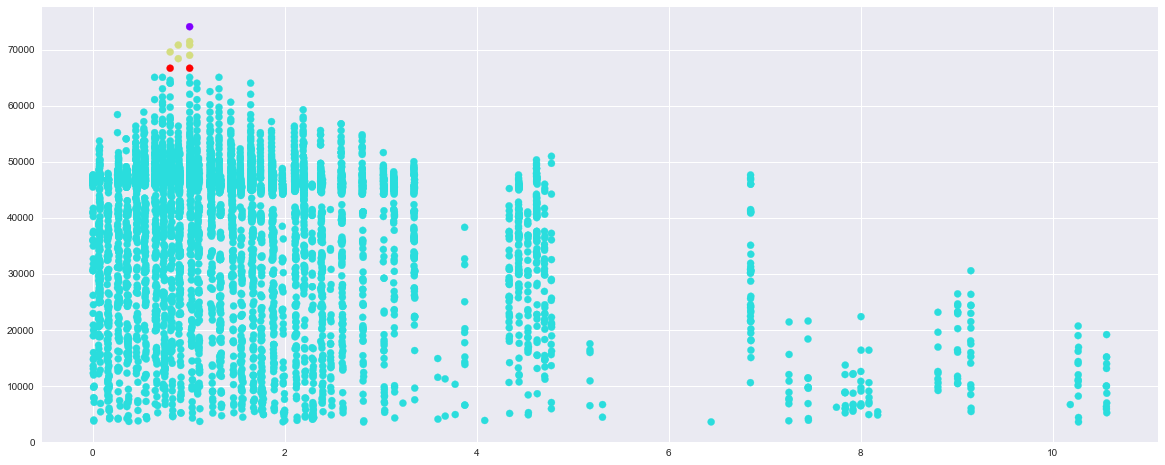

In [78]:
# Approach 4: Use clustering algorithms. 
# Ineffective so far: K means, DBSCAN

import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Load file into 2d list
filename = 'P7132033_37'
with open('../data/'+ filename + '.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats and remove low frequency values
zc_x = list()
zc_y = list()
zc = list()
for x, y in zc_str:
        zc_x.append(float(x))
        zc_y.append(float(y))
        zc.append([float(x), float(y)])

# Cluster
# eps- 40 < eps < 1250
clustering = DBSCAN(eps=1250, min_samples=2).fit(zc)

plt.figure(figsize=(20,8))
plt.scatter(zc_x, zc_y, c=clustering.labels_, s=50, cmap='rainbow');

# Graph data
trace_noisy = graphs.Scatter(
                            x = zc_x, 
                            y = zc_y,
                            mode = 'markers',
                            name = 'ZC- noisy'
                        )

shapes = list()
layout = graphs.Layout(shapes=shapes)
trace = [trace_noisy]
figure={
    'data': trace,
    'layout': layout
   }
#py.iplot(figure, filename=filename)

In [80]:
# Approach 5: Same as 3, using LOESS instead of savitzky-golay

import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
from batcall import batcall
from statsmodels.nonparametric.smoothers_lowess import lowess

# Magic numbers
dy_cutoff = 100
cutoff = 2000
avg_d = 3000
pulse_size = 30

# Load file into 2d list
filename = 'P7132033_37'
with open('../data/'+ filename + '.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats and remove low frequency values
zc_x = list()
zc_y = list()
for x, y in zc_str:
        zc_x.append(float(x))
        zc_y.append(float(y))
    
# Get dy
prev_y = 0
dy = list()
for y in zc_y:
    dy.append(abs(y-prev_y))
    prev_y = y

# Smooth holes
i = 1
while i < len(dy):
    if dy[i] > dy_cutoff:
        if dy[i - 1] < dy_cutoff:
            if dy[i + 1] < dy_cutoff:
                zc_y[i] = (zc_y[i - 1] + zc_y[i + 1])/2
            elif dy[i + 2] < dy_cutoff:
                zc_y[i] = (zc_y[i - 1] + zc_y[i + 2])/2
        elif dy[i - 2] < dy_cutoff:
            if dy[i + 1] < dy_cutoff:
                zc_y[i] = (zc_y[i - 2] + zc_y[i + 1])/2
            elif dy[i + 2] < dy_cutoff:
                zc_y[i] = (zc_y[i - 2] + zc_y[i + 2])/2
    i += 1

# Smooth graph- Loess
yhat4 = lowess(zc_y, zc_x, 0.05)
yhat4.sort()
print (yhat4)

# Compare smoothed and original
i = 0
noiseless_y = list()
noiseless_x = list()
pulses = list()
dy = list()
bcs = list()
while i < len(zc_x):
    j = i - 1
    average = 0
    
    # Find closely grouped points and clump them together
    while j < len(zc_x) and numpy.sqrt((zc_x[j] - zc_x[j - 1])**2 + (zc_y[j] - zc_y[j - 1])**2) <= avg_d:
        
        # Variance between smooth graph and original
        average += abs(zc_y[j] - yhat4[j])
        j += 1
        
    # Filter out pulses that are too small or too noisy
    if (j - i > pulse_size):
        
        if 12 / (j - i) <= cutoff:
        
            # Add pulse lines
            pulses.append(zc_x[i])
            bc = list()

            # Build noiseless graph
            while i < j:
                noiseless_y.append(zc_y[i])
                noiseless_x.append(zc_x[i])
                bc.append([zc_x[i], zc_y[i]])
                i += 1

            # Add pulse lines
            pulses.append(zc_x[i])
            bcs.append(bc)
    i += 1
    
# Graph data
trace_noisy = graphs.Scatter(
                            x = zc_x, 
                            y = zc_y,
                            mode = 'markers',
                            name = 'ZC- noisy'
                        )
trace_smooth = graphs.Scatter(
                            x = zc_x, 
                            y = yhat4,
                            name = 'ZC- smoothed'
                        )
trace_noiseless = graphs.Scatter(
                            x = noiseless_x, 
                            y = noiseless_y,
                            mode = 'markers',
                            name = 'ZC- noiseless'
                         )

shapes = list()
for i in pulses:
    shapes.append({'type': 'line',
                   'xref': 'x',
                   'yref': 'y',
                   'x0': i,
                   'y0': 0,
                   'x1': i,
                   'y1': 100000,
                   'line': {
                        'color': 'rgb(139, 0, 0)',
                        'width': 1,
                    },
                  })
layout = graphs.Layout(shapes=shapes)
trace = [trace_noisy, trace_smooth, trace_noiseless]
figure={
    'data': trace,
    'layout': layout
   }
py.iplot(figure, filename=filename)
# return bcs

[[0.00000000e+00 3.84530319e+04]
 [8.90000000e-05 3.84503495e+04]
 [1.74000000e-04 3.84477891e+04]
 ...
 [1.05614250e+01 1.11810486e+04]
 [1.05619430e+01 1.11803307e+04]
 [1.05623480e+01 1.11797694e+04]]


In [4]:
import csv, numpy
import plotly.plotly as py
import plotly.graph_objs as graphs
import numpy as np

# Load file into 2d list
filename = 'P7132033_37'
with open('../data/'+ filename + '.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    zc_str = list(reader)

# Format zc_str to floats and remove low frequency values
zc_x = list()
zc_y = list()
zc = list()
for x, y in zc_str:
        zc_x.append(float(x))
        zc_y.append(float(y))
        zc.append([float(x), float(y)])

dist = list()
j = 1
while j < len(zc_x):
    dist.append(numpy.sqrt((zc_x[j] - zc_x[j - 1])**2 + (zc_y[j] - zc_y[j - 1])**2))
    j+=1
    
neighbors = list()
i = 1
while i < len(zc_x):
    j = i
    count = 0
    while numpy.sqrt((zc_x[j] - zc_x[j - 1])**2 + (zc_y[j] - zc_y[j - 1])**2) <= 1250:
        count += 1
        j += 1
    neighbors.append(count)
    i += 1

data = [graphs.Histogram(x=dist)]
py.iplot(data, filename = "testHisto")


In [86]:
! pip install -U --user hmmlearn


  Running setup.py bdist_wheel for hmmlearn: started
  Running setup.py bdist_wheel for hmmlearn: finished with status 'error'
  Complete output from command D:\Programs\Anaconda\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\HADISO~1\\AppData\\Local\\Temp\\pip-install-uxm3z1bv\\hmmlearn\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\HADISO~1\AppData\Local\Temp\pip-wheel-fvjbijsq --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.6
  creating build\lib.win-amd64-3.6\hmmlearn
  copying hmmlearn\base.py -> build\lib.win-amd64-3.6\hmmlearn
  copying hmmlearn\hmm.py -> build\lib.win-amd64-3.6\hmmlearn
  copying hmmlearn\utils.py -> build\lib.win-amd64-3.6\hmmlearn
  copying hmmlearn\__init__.py -> build\lib.win-amd64-3.6\hmmlearn
  creating build\lib.win-amd64-3.6\hmmlearn\tests
  

  Failed building wheel for hmmlearn
distributed 1.21.8 requires msgpack, which is not installed.
Command "D:\Programs\Anaconda\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\HADISO~1\\AppData\\Local\\Temp\\pip-install-uxm3z1bv\\hmmlearn\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\HADISO~1\AppData\Local\Temp\pip-record-vrmm90br\install-record.txt --single-version-externally-managed --compile --user --prefix=" failed with error code 1 in C:\Users\HADISO~1\AppData\Local\Temp\pip-install-uxm3z1bv\hmmlearn\
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
